### Machine Learning using NLP of Wine Descriptions
**Goal:** perform NLP on wine descriptions (using TF-IDF). Use the TF-IDF scores, along with other wine info, to build a machine learning algorithm that can predict the rating score for wine.

**Input:**  A csv file of reviews with descripitons, varietals, region, and score from Wine Enthusiast Magazine. CSV was obtained from use zackthoutt on kaggle.com: [wine review data](https://www.kaggle.com/zynicide/wine-reviews). This dataset is 150,000 wine reviews, and only includes wines with scores from 80-100. The dataset has been cleaned to include only those reviews that include price (many had no listed price.) The cleaned dataset contains approximately 120,000 entries.

**Expected Output:** A machine learnign algorithm that can take in:
1. Wine description (textual)
2. Country of origin
3. Designation (optional) - this is more specific data about the wine
4. Price
5. Province (optional)
6. Region
7. Varietal
8. Winery

**The algorithm should then output a score (from 80-100).**

Initially, we will create an algorithm that will attempt to predict score from *only* the text description, and will then compare this to an ML algorithm including text data in addition to the other wine data.

In [76]:
# import dependencies

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
import seaborn as sns
import pickle
sns.set_style("whitegrid")

In the dependencies above we have:
+ pandas for importing and manipulating raw data
+ numpy for array operations
+ sklearn MultinomialNB and SGDClassifier - these are two ML models we will test
+ sklearn train_test_split to split our data into training data and testing data easily
+ sklearn CountVectorizer and TfidfTransformer - to turn textual data into a numerical vector, and then analyze the data to determine the most relevant words
+ sklearn metrics is used to get more information about how well models are working

In [2]:
#load the data into a pandas dataframe
data = os.path.join('data/winemag-data-130k-prices-only.csv')
df = pd.read_csv(data)

In [3]:
#check to see that the data loaded correctly
df.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
1,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
2,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
3,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
4,5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,NaN,Michael Schachner,@wineschach,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem


In [4]:
df.dtypes

Unnamed: 0                 int64
country                   object
description               object
designation               object
points                     int64
price                    float64
province                  object
region_1                  object
region_2                  object
taster_name               object
taster_twitter_handle     object
title                     object
variety                   object
winery                    object
dtype: object

In [5]:
#now we need to use the 'description' column, and perform some nlp on this to extract usable data.
#first we will construct a new df with just description text and points
text_df = pd.DataFrame({'points': df.points, 'description': df.description})
text_df.head()

,description,points
0,"This is ripe and fruity, a wine that is smooth...",87
1,"Tart and snappy, the flavors of lime flesh and...",87
2,"Pineapple rind, lemon pith and orange blossom ...",87
3,"Much like the regular bottling from 2012, this...",87
4,Blackberry and raspberry aromas show a typical...,87


We will now map points to stars to "bin" the points into 5 bins for easier classification

In [6]:
text_df['stars'] = text_df['points'].map({80:1, 81:1, 82:1, 83:1, 84:2, 85:2,\
                    86:2, 87:2, 88:3, 89:3, 90:3, 91:3, 92:4, 93:4, 94:4, 95:4, 96:5, 97:5, 98:5, 99:5, 100:5})

In [7]:
text_df.head(10)

,description,points,stars
0,"This is ripe and fruity, a wine that is smooth...",87,2
1,"Tart and snappy, the flavors of lime flesh and...",87,2
2,"Pineapple rind, lemon pith and orange blossom ...",87,2
3,"Much like the regular bottling from 2012, this...",87,2
4,Blackberry and raspberry aromas show a typical...,87,2
5,"Here's a bright, informal red that opens with ...",87,2
6,This dry and restrained wine offers spice in p...,87,2
7,Savory dried thyme notes accent sunnier flavor...,87,2
8,This has great depth of flavor with its fresh ...,87,2
9,"Soft, supple plum envelopes an oaky structure ...",87,2


In [8]:
#let's first look at max and min length descriptions to see if there is any major difference
text_df['description'].map(lambda x: len(x)).max()

829

In [9]:
text_df['description'].map(lambda x: len(x)).min()

20

In [10]:
#let's add a new column that is the length. We will use this to feed into a predictive model to see if just the description
#length alone could be predictive of score.
text_df['length'] = text_df['description'].map(lambda x: len(x))
text_df.head()

,description,points,stars,length
0,"This is ripe and fruity, a wine that is smooth...",87,2,227
1,"Tart and snappy, the flavors of lime flesh and...",87,2,186
2,"Pineapple rind, lemon pith and orange blossom ...",87,2,199
3,"Much like the regular bottling from 2012, this...",87,2,249
4,Blackberry and raspberry aromas show a typical...,87,2,261


In [11]:
#let's also see what the mean leangth (in characters) the descriptions are
text_df['description'].map(lambda x: len(x)).mean()

244.24520768753874

In [12]:
#We will set our y values to be the output (in points) for each record:
y = text_df.points.values
y

array([87, 87, 87, ..., 90, 90, 90], dtype=int64)

In [13]:
#we will set Z to be the length (rather than X. We will use X later for the actual text.)
Z = text_df.length.values.reshape(-1,1)
Z

array([[227],
       [186],
       [199],
       ...,
       [225],
       [216],
       [169]], dtype=int64)

In [14]:
Z_train, Z_test, y_train, y_test = train_test_split(Z, y, random_state=42)

In [15]:
#now we will run a naive Bayes classifier on the text length only.

Zmnb = MultinomialNB().fit(Z_train, y_train)

In [16]:
print(f"Training Data Score: {Zmnb.score(Z_train, y_train)}")

Training Data Score: 0.13176312395983733


We can see that we were not able to get good results from the algorithm using just length. We could try to use a different model, or tweak the model. However, initial exploratory data analysis shows there is not a great correlation between description legnth and points, with too much overlap between wines of different point values.

We will instead move on to performing NLP on the textual data and see if we can create a decent predictive model from that.

In [17]:
X = text_df.description.tolist()

In [18]:
#run train test split on the textual X data and y data:

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [19]:
len(X_train)

90731

In [20]:
#examine the X data to ensure it looks right
X_train[:5]

["An unusual blend of Riesling, Albariño and Sauvignon Blanc that is largely neutral on the nose and then waxy, honeyed and pithy in the mouth. Along the way there's an appealing dry, melony, petrol character and some good old-fashioned tang. A breed unto itself.",
 "Coronato is a robust, modern super Tuscan only produced for export markets. Indeed, you can sense a New World appeal within its rich, succulent fabric thanks to penetrating notes of coffee, espresso, tar, aniseed, chocolate and bursting cherry. It's soft and velvety with enormous charm.",
 "This isn't the most powerful, impressive Pinot Noir from the Sonoma Coast, but it has a lot going for it. It's bone dry, crisply acidic and elegant on the palate, with a flavor of sour cherry candy that's savory and clean. Drink now.",
 "Alluring aromas of cocoa powder, berry fruits, graphite and raw oak lead to a jammy palate with density and weight. This old-vines Monastrell tastes of chocolaty oak and herbal blackberry. On the finish

In [21]:
len(X_test)

30244

In [22]:
#we will now run CountVectorizer.fit on the description data. We will do this on ONLY the training data (not the test data)
#because we want to build a model that is able to take is data it has not seen and still work.

#After we have fit the X_train data to CountVectorizer, we can then use the fitted model to transform our X_test data.

vect = CountVectorizer()

In [23]:
#Here we fit the data to the CountVectorizer (which effectively trains it) and then we transform the X_train data, which will
#change the data into a numerical array. We can run fit_transform to do the fit and transform in one action.
X_train_counts = vect.fit_transform(X_train)

In [24]:
X_train_counts.shape

(90731, 27432)

In [31]:
#let's examine our data
vect.get_feature_names()

['000',
 '008',
 '01',
 '02',
 '03',
 '030',
 '04',
 '04s',
 '05',
 '056',
 '06',
 '061',
 '064',
 '07',
 '07s',
 '08',
 '080',
 '08s',
 '09',
 '093',
 '09s',
 '10',
 '100',
 '100th',
 '101',
 '1016',
 '103',
 '104',
 '106',
 '107th',
 '108',
 '10th',
 '11',
 '110',
 '111',
 '112',
 '114',
 '115',
 '116',
 '1194',
 '11th',
 '12',
 '120',
 '1200',
 '122',
 '125',
 '1252',
 '126',
 '128',
 '1290',
 '12g',
 '12th',
 '13',
 '130',
 '130th',
 '132',
 '133',
 '134',
 '135',
 '136',
 '137',
 '1375',
 '1396',
 '13g',
 '13th',
 '14',
 '140',
 '1429',
 '146',
 '147',
 '14g',
 '14th',
 '15',
 '150',
 '1500',
 '150th',
 '154',
 '155g',
 '159g',
 '15g',
 '15s',
 '15th',
 '16',
 '160',
 '1600',
 '1607',
 '160g',
 '161',
 '1610',
 '1628',
 '164',
 '1649',
 '165',
 '1667',
 '1690',
 '1692',
 '16g',
 '16th',
 '17',
 '170',
 '1700s',
 '170g',
 '171',
 '172',
 '1737',
 '1740',
 '1744',
 '175',
 '1756',
 '1759',
 '177',
 '1772',
 '1780',
 '1787',
 '1789',
 '179',
 '17th',
 '18',
 '180',
 '1800',
 '1800s',

We ran CountVectorizer and seaprated our text into only 1-grams (single words.) We can see that there are many "words" which contain numerical data that may not be useful to our model. So we will make a stop-words list from the numerical values.

We won't use this list right now, but will reserve it for testing if our original vectorization of the text data doesn't work well.

In [32]:
#make a list of the numerical feature names
#examining the data we can see that the numerical features go to index 540
stop_list = vect.get_feature_names()
stop_list = stop_list[:540]

In [33]:
#We will now do a TF-IDF transform on the data - first we fit the model (like with CountVectorizer) and then we transform
#the training data
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(90731, 27432)

In [34]:
type(X_train_tfidf)

scipy.sparse.csr.csr_matrix

We can see the output is a sparse matrix (which only stores non-zero values so uses up much less memory than a dense matrix.) A dense matrix would store all values.

In [35]:
#now we will try fitting our training data to a naive Bayes model
mnb = MultinomialNB().fit(X_train_tfidf, y_train)

In [36]:
print(f"Training Data Score: {mnb.score(X_train_tfidf, y_train)}")

Training Data Score: 0.27863684958834356


Ok, so we can see here that our Naive Bayes model using only the descriptions does not product a good predictive model even on the training data. We should next test a Support Vector Machine model.

In [37]:
#We will instantiate the sgdc model with some defaults:
sgdc = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None).fit(X_train_tfidf, y_train)

In [38]:
print(f"Training Data Score: {sgdc.score(X_train_tfidf, y_train)}")

Training Data Score: 0.4703133438405837


This is an improvement, but still not where we would like to be.

In [39]:
#now let's try tweaking the settings on the countvectorizer on our original data. 
#We will include bi-grams and will remove extraneous words (those created above in our stop words list.)
#We will also limit our word list to only words that appear in at least 3 different descriptions (min_df=3)

vect = CountVectorizer(min_df=3, stop_words=stop_list, ngram_range=(1,2))

In [40]:
X_train_counts = vect.fit_transform(X_train)

In [41]:
vect.get_feature_names()

['aaron',
 'aaron jackson',
 'aaron pott',
 'abacela',
 'abandon',
 'abate',
 'abate fetel',
 'abbey',
 'abbey ridge',
 'abbott',
 'abbreviated',
 'abbreviated finish',
 'abeja',
 'abelé',
 'abilities',
 'ability',
 'ability of',
 'ability to',
 'able',
 'able to',
 'ably',
 'ably marries',
 'abnormal',
 'abound',
 'abound along',
 'abound and',
 'abound from',
 'abound here',
 'abound in',
 'abound it',
 'abound on',
 'abound the',
 'abound there',
 'abound throughout',
 'abound while',
 'abound with',
 'abounds',
 'abounds in',
 'abounds on',
 'abounds with',
 'abouriou',
 'abouriou grape',
 'about',
 'about acid',
 'about all',
 'about an',
 'about and',
 'about any',
 'about anything',
 'about as',
 'about average',
 'about balance',
 'about berry',
 'about black',
 'about bright',
 'about but',
 'about buttered',
 'about chardonnay',
 'about cherries',
 'about citrus',
 'about complexity',
 'about crisp',
 'about dark',
 'about delicious',
 'about dry',
 'about easy',
 'about eleg

Inspecting the feature names (1-grams and bi-grams) we can now see the bi-grams in our list.

In [42]:
X_train_counts.shape

(90731, 138220)

In [43]:
#now we will run multinomial Bayes using just the vectozied data (no tf_idf run)
mnb = MultinomialNB().fit(X_train_counts, y_train)

In [44]:
print(f"Training Data Score: {mnb.score(X_train_counts, y_train)}")

Training Data Score: 0.6836362434008222


Better! let's run the test data on this. First we must use our vect model to transform the X_test data.

In [45]:
X_test_counts = vect.transform(X_test)

In [46]:
print(f"MNB on non-tfidf Testing Data Score: {mnb.score(X_test_counts, y_test)}")

MNB on non-tfidf Testing Data Score: 0.26626768945906626


This is not nearly as good on our testing data, but still an improvement. Let's test this on the SGDClassifier.

In [47]:
sgdc = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None).fit(X_train_counts, y_train)

In [48]:
print(f"SGDC Training Data Score: {sgdc.score(X_train_counts, y_train)}")

SGDC Training Data Score: 0.6254532629421036


In [49]:
print(f"SGDC on non-tfidf Testing Data Score: {sgdc.score(X_test_counts, y_test)}")

SGDC on non-tfidf Testing Data Score: 0.24189921967993652


Both model show very similar results. Let's now do a TF-IDF transform on the X data, re-fit our models, and test.

In [50]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [51]:
mnb = MultinomialNB().fit(X_train_tfidf, y_train)

In [52]:
print(f"MNB Training Data Score w/ TF-IDF data: {mnb.score(X_train_tfidf, y_train)}")

MNB Training Data Score w/ TF-IDF data: 0.35712160121678366


.357! That looks worse.

Next is SGDC on TF_IDF data

In [53]:
sgdc = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=1, max_iter=5, tol=None).fit(X_train_tfidf, y_train)

In [54]:
print(f"SGDC Training Data Score on TF-IDF data: {sgdc.score(X_train_tfidf, y_train)}")

SGDC Training Data Score on TF-IDF data: 0.9160264959054788


Looks good!

Now to run on our test data. First we will have to transform the test X data using our vectorizer (with just transform), and also with tf_idf

In [55]:
X_test_counts = vect.transform(X_test)

In [56]:
X_test_counts.shape

(30244, 138220)

In [57]:
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

In [58]:
X_test_tfidf.shape

(30244, 138220)

In [59]:
print(f"SGDC Testing Data Score with bi-grams and TF-IDF: {sgdc.score(X_test_tfidf, y_test)}")

SGDC Testing Data Score with bi-grams and TF-IDF: 0.27965877529427324


Well that's not nearly as nice as the training data. But, it could still be usable. Let's examine the results a bit more.

In [60]:
#picking a data point at random to see how far off the predicted score is vs. the real score
print(sgdc.predict(X_test_tfidf[3006]))
print(y_test[3006])

[85]
85


Ok so clearly we are seeing some correct scores. Let's look at overall accuracy, the average error.

In [61]:
#We will make a "predicted" object that is all predictions from the model
predicted = sgdc.predict(X_test_tfidf)

In [62]:
metrics.accuracy_score(y_test, predicted)

0.27965877529427324

In [63]:
metrics.mean_squared_error(y_test, predicted)

5.24530485385531

In [64]:
metrics.mean_absolute_error(y_test, predicted)

1.6262729797645814

In [65]:
metrics.r2_score(y_test, predicted)

0.43732827611134373

### Looks not bad!

We can see above that our model with text only is 27% accurate in predicting the correct score (from 80-100) with a mean error of only 1.6. I'd say that's actually pretty good.

Conditions: 
+ vect = CountVectorizer(min_df=3, stop_words=stop_list, ngram_range=(1,2))
+ tfidf_transformer = TfidfTransformer()
+ sgdc = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None).fit(X_train_tfidf, y_train)

### Score Predictive Function

Next let's have some fun, and build a function that will take in a string (a "fake" description created by the user) and then give a score to this imaginary wine.

In [66]:
def desc_predict():
    words = input("Please enter a description for the wine: ")
    words_list = [words]
    words_count = vect.transform(words_list)
    words_tfidf = tfidf_transformer.transform(words_count)
    predict_score = sgdc.predict(words_tfidf)
    print("This wine deserves a score of...")
    print(predict_score[0])

In [67]:
desc_predict()

Please enter a description for the wine: Outstanding. This wine is breathtaking and bold.
This wine deserves a score of...
96


That actually works surprisingly well. I am pretty happy with this.

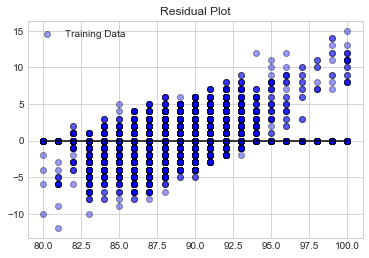

In [68]:
#Now we will plot training data residuals
plt.scatter(sgdc.predict(X_train_tfidf), sgdc.predict(X_train_tfidf) - y_train, color="blue", edgecolor="black", alpha=.4, label="Training Data")
plt.legend()
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())
plt.title("Residual Plot")
plt.show()

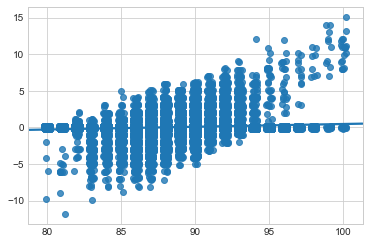

In [71]:
#let's plot the same data using Seaborn to introduce a jitter to better visualize the density of results
ax = sns.regplot(sgdc.predict(X_train_tfidf), sgdc.predict(X_train_tfidf) - y_train, x_jitter=.2, y_jitter=.2)

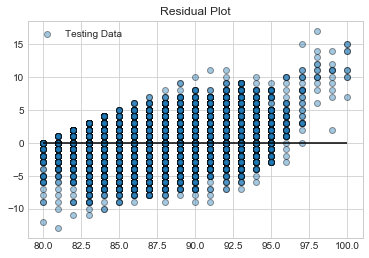

In [69]:
#Next let's plot testing data residuals
plt.scatter(sgdc.predict(X_test_tfidf), sgdc.predict(X_test_tfidf) - y_test, edgecolor="black", alpha=.4, label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())
plt.title("Residual Plot")
plt.show()

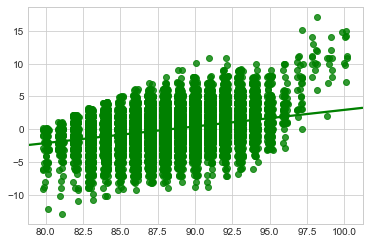

In [72]:
#same plot as above, but using Seaborn with jitter
ax = sns.regplot(sgdc.predict(X_test_tfidf), sgdc.predict(X_test_tfidf) - y_test, x_jitter=.2, y_jitter=.2, color="g")

After plotting residuals, one can definitely see the greater spread of residuals in the testing data.

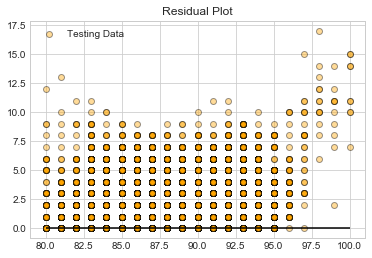

In [70]:
#I want to plot absolute value of the residuals, since the boundaies and 80 and 100 mean as we near those, our error
#skews in only one direction. I want to see how consistent our error is across the data
plt.scatter(sgdc.predict(X_test_tfidf), abs(sgdc.predict(X_test_tfidf) - y_test), \
            color="orange", edgecolor="black", alpha=.4, label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())
plt.title("Residual Plot")
plt.show()

Let's also look at the distribution of residuals for training and test data in a histogram

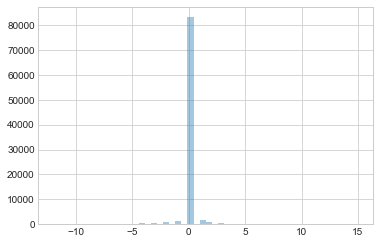

In [73]:
x = sgdc.predict(X_train_tfidf) - y_train
sns.distplot(x, kde=False)

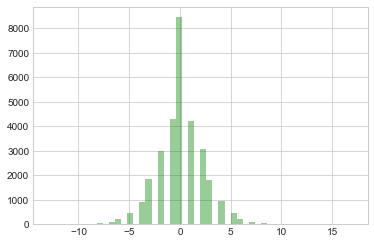

In [74]:
x = sgdc.predict(X_test_tfidf) - y_test
sns.distplot(x, kde=False, color='g')

In [75]:
#Let's also check and see what % of predictions are 2 or less off
count = 0
for i in range(len(predicted)):
    if abs(predicted[i] - y_test[i]) <= 2:
        count += 1
print("The precentage of predictions with an error under 2 is " + str(count / len(y_test) * 100))

The precentage of predictions with an error under 2 is 76.03491601639995


In [78]:
#save the working model to disk to call it in a Flask app later
filename = 'wine_text_model.sav'
pickle.dump(sgdc, open(filename, 'wb'))